<a href="https://colab.research.google.com/github/mhaghpanah/PyTorch-Tutorials/blob/main/cifar10_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a classifier


## Training an image classifier

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True,
                                          num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, 
                                         num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


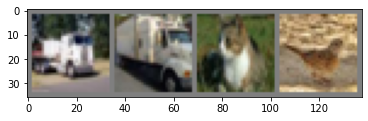

truck truck   cat  bird


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Training on GPU

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Define a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return x

net = Net()

In [6]:
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Define a Loss function and optimizer

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [8]:
for epoch in range(2):

  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    # inputs, labels = data
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
      running_loss = 0.0
  print('Finished Training')

[1,  2000] loss: 2.620
[1,  4000] loss: 1.844
[1,  6000] loss: 1.624
[1,  8000] loss: 1.535
[1, 10000] loss: 1.504
[1, 12000] loss: 1.440
Finished Training
[2,  2000] loss: 1.364
[2,  4000] loss: 1.347
[2,  6000] loss: 1.332
[2,  8000] loss: 1.313
[2, 10000] loss: 1.295
[2, 12000] loss: 1.252
Finished Training


In [9]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network on the test data

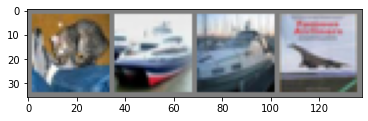

GroundTruth:    cat ship shipplane


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ''.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [12]:
outputs = net(images)

In [13]:
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ''.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    catplane shipplane


In [14]:
correct = 0
total = 0
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % 
      (100 * correct / total))


Accuracy of the network on the 10000 test images: 56 %


In [15]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
  for data in testloader:
    images, labels = data
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
      label = labels[i]
      class_correct[label] += c[i].item()
      class_total[label] += 1
for i in range(10):
  print('Accuracy on %5s : %2d %%' % 
        (classes[i], 100*class_correct[i]/class_total[i]))

Accuracy on plane : 64 %
Accuracy on   car : 69 %
Accuracy on  bird : 46 %
Accuracy on   cat : 42 %
Accuracy on  deer : 49 %
Accuracy on   dog : 41 %
Accuracy on  frog : 66 %
Accuracy on horse : 63 %
Accuracy on  ship : 70 %
Accuracy on truck : 52 %
